# Random Forest Model without Automatic Feature Engineering

In this notebook, we will focus on achieving better performance by choosing the most important features through **Feature Reduction**

## 1. Loading Data and Packages

In [0]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Importing the dataset
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
dataset = pd.read_csv('housing.csv', delim_whitespace=True, names=column_names)
dataset.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


## 2. Analyzing the data

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


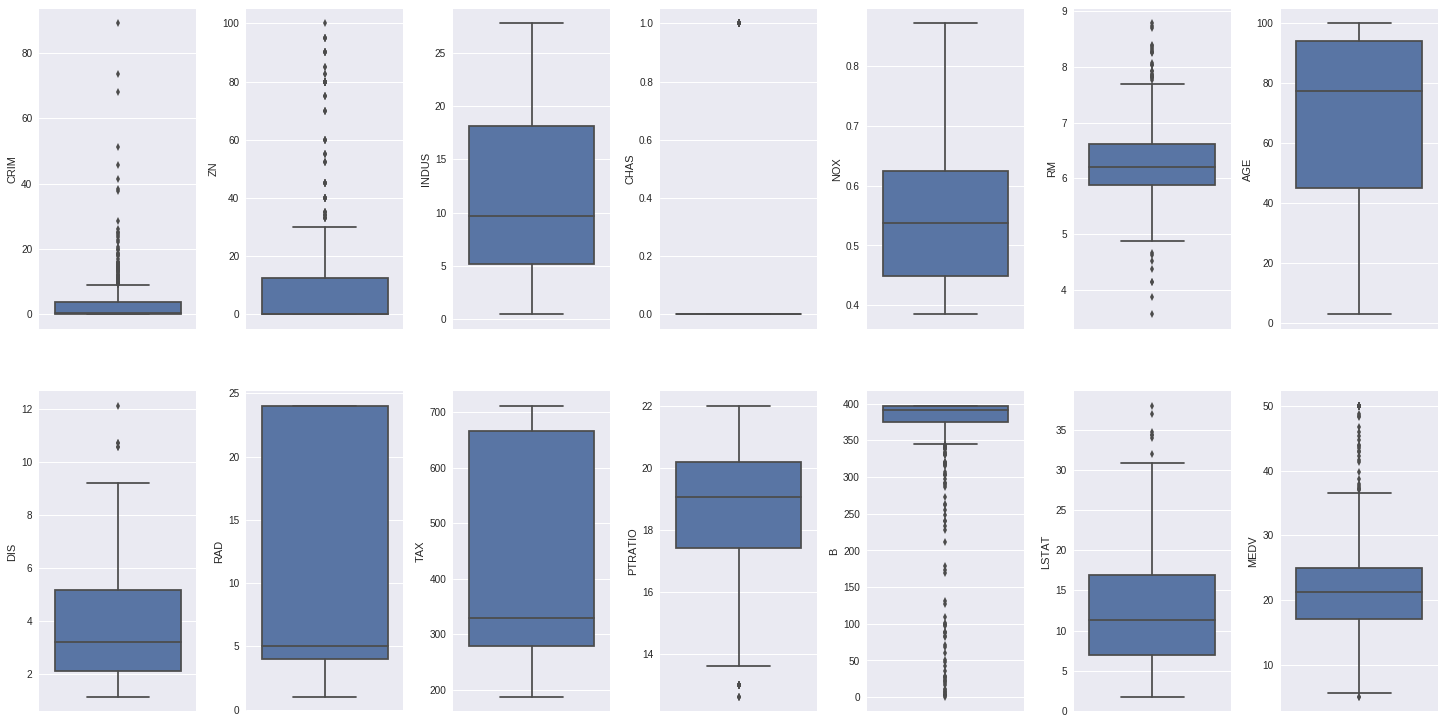

In [3]:
# visualize the dataset
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()

# draw boxplots with vertical orientation
for k,v in dataset.items():
    sns.boxplot(y=k, data=dataset, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=1, h_pad=5.0)

Columns like CRIM, ZN, RM, B seems to have outliers. Let's see the outliers percentage in every column.

In [4]:
# Let's see the outliers percentage in every column.
for k, v in dataset.items():
        q1 = v.quantile(0.25)
        q3 = v.quantile(0.75)
        irq = q3 - q1
        v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
        perc = np.shape(v_col)[0] * 100.0 / np.shape(dataset)[0]
        print("Column %s outliers = %.2f%%" % (k, perc))

Column CRIM outliers = 13.04%
Column ZN outliers = 13.44%
Column INDUS outliers = 0.00%
Column CHAS outliers = 100.00%
Column NOX outliers = 0.00%
Column RM outliers = 5.93%
Column AGE outliers = 0.00%
Column DIS outliers = 0.99%
Column RAD outliers = 0.00%
Column TAX outliers = 0.00%
Column PTRATIO outliers = 2.96%
Column B outliers = 15.22%
Column LSTAT outliers = 1.38%
Column MEDV outliers = 7.91%


## 3. Data Preprocessing

Let's remove MEDV outliers (MEDV = 50.0)  and RM outliers (RM = 8.78) .

In [5]:
dataset = dataset[~(dataset['MEDV'] >= 50.0)]
dataset = dataset[~(dataset['RM'] >= 8.78)]
print(np.shape(dataset))

(489, 14)


In [6]:
y = dataset['MEDV']
X = dataset.drop('MEDV', axis = 1)
dataset.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [0]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 4. Fitting the Base Model

In [8]:
# Fitting the RandomForest Regression Model to the dataset
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=1000, random_state=42)
regressor.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [0]:
# Predicting a new result
y_pred = regressor.predict(X_test)

In [10]:
# Calculating accuracy using r2_score
from sklearn.metrics import r2_score
train_score = round(regressor.score(X_train, y_train)*100,2)
test_score = round(r2_score(y_test, y_pred)*100,2)
print('----------------Model Performance---------------')
print("Train_accuracy_Base :" + str(train_score))
print("Test_accuracy_Base :" + str(test_score))

----------------Model Performance---------------
Train_accuracy_Base :98.23
Test_accuracy_Base :89.46


## 5. Feature Reduction

From previous experience and the graphs produced at the beginning, we know that some features are not useful for our problem. To reduce the number of features, which will reduce runtime, hopefully without significantly reducing performance, we can examine the feature importances from the random forest.



**Feature Importances**

In [0]:
# List of features for later use
feature_list = list(X.columns)

# Get numerical feature importances
importances = list(regressor.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

In [12]:
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: LSTAT                Importance: 0.44
Variable: RM                   Importance: 0.39
Variable: CRIM                 Importance: 0.04
Variable: NOX                  Importance: 0.03
Variable: DIS                  Importance: 0.02
Variable: PTRATIO              Importance: 0.02
Variable: INDUS                Importance: 0.01
Variable: AGE                  Importance: 0.01
Variable: TAX                  Importance: 0.01
Variable: B                    Importance: 0.01
Variable: ZN                   Importance: 0.0
Variable: CHAS                 Importance: 0.0
Variable: RAD                  Importance: 0.0


 **Visualize Feature Importances**

Text(0.5, 1.0, 'Variable Importances')

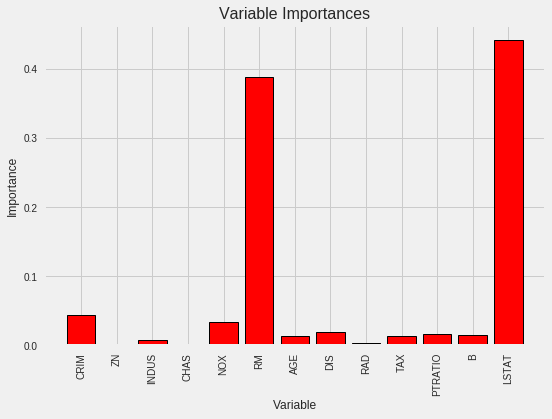

In [13]:
# Reset style 
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1)

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical', fontsize=10)

# Axis labels and title
plt.ylabel('Importance', fontsize=12)
plt.xlabel('Variable', fontsize=12)
plt.title('Variable Importances', fontsize=16)

In [0]:
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]

Text(0.5, 1.0, 'Cumulative Importances')

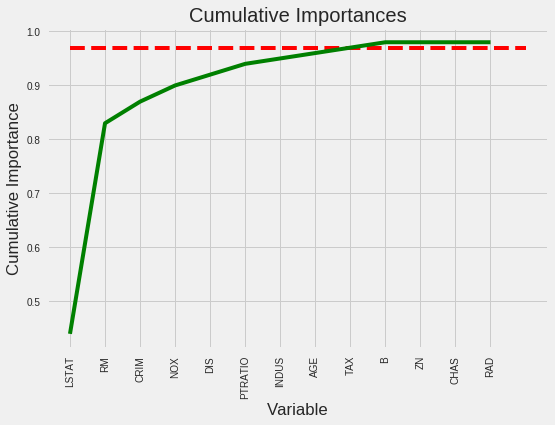

In [15]:
# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)

# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')

# Draw line at 95% of importance retained
plt.hlines(y = 0.97, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable')
plt.ylabel('Cumulative Importance') 
plt.title('Cumulative Importances')

**Limit Number of Features**

We will now reduce the number of features in use by the model to only those required to account for 97% of the importance. The same number of features must be used in the training and testing sets.

In [16]:
# Find number of features for cumulative importance of 97%
# Add 1 because Python is zero-indexed
print('Number of features for 97% importance:', np.where(cumulative_importances > 0.97)[0][0] + 1)

Number of features for 97% importance: 9


In [17]:
# Extract the names of the most important features
important_feature_names = [feature[0] for feature in feature_importances[0:9]]
# Find the columns of the most important features
important_indices = [feature_list.index(feature) for feature in important_feature_names]

# Create training and testing sets with only the important features
important_train_features = X_train.iloc[:, important_indices]
important_test_features = X_test.iloc[:, important_indices]

# Sanity check on operations
print('Important train features shape:', important_train_features.shape)
print('Important test features shape:', important_test_features.shape)

Important train features shape: (391, 9)
Important test features shape: (98, 9)


**Training on Important Features**

In [0]:
# Train the model on only the important features
regressor.fit(important_train_features, y_train);

**Evaluate on Important features**

In [0]:
# Make predictions on test data
predictions = regressor.predict(important_test_features)

In [20]:
# Calculating accuracy using r2_score
from sklearn.metrics import r2_score
train_score = round(regressor.score(important_train_features, y_train)*100,2)
test_score = round(r2_score(y_test, predictions)*100,2)
print('----------------Model Performance---------------')
print("Train_accuracy_Reduced :" + str(train_score))
print("Test_accuracy_Reduced :" + str(test_score))

----------------Model Performance---------------
Train_accuracy_Reduced :98.2
Test_accuracy_Reduced :89.0


Using only the 9 most important features (instead of all 13) results in a minor decrease in accuracy by 0.46 percent. For some models, decreasing the number of features can increase performance and therefore should be done. However, in other situations, performance will decrease but run time will also decrease. The final decision on how many features to retain will therefore be a trade-off between accuracy and run time.

## 6. Compare Trade-Offs

In [21]:
# Use time library for run time evaluation
import time

# All features training and testing time
all_features_time = []

# Do 10 iterations and take average for all features
for _ in range(10):
    start_time = time.time()
    regressor.fit(X_train, y_train)
    all_features_predictions = regressor.predict(X_test)
    end_time = time.time()
    all_features_time.append(end_time - start_time)

all_features_time = np.mean(all_features_time)
print('All features total training and testing time:', round(all_features_time, 2), 'seconds.')

All features total training and testing time: 2.43 seconds.


In [22]:
# Time training and testing for reduced feature set
reduced_features_time = []

# Do 10 iterations and take average
for _ in range(10):
    start_time = time.time()
    regressor.fit(important_train_features, y_train)
    reduced_features_predictions = regressor.predict(important_test_features)
    end_time = time.time()
    reduced_features_time.append(end_time - start_time)

reduced_features_time = np.mean(reduced_features_time)
print('Reduced features total training and testing time:', round(reduced_features_time, 2), 'seconds.')

Reduced features total training and testing time: 2.11 seconds.


**Accuracy vs Run-Time**

In [23]:
all_accuracy =  round(r2_score(y_test, y_pred)*100,2)
reduced_accuracy = round(r2_score(y_test, predictions)*100,2)

comparison = pd.DataFrame({'features': ['all (17)', 'reduced (5)'], 
                           'run_time': [round(all_features_time, 2), round(reduced_features_time, 2)],
                           'accuracy': [round(all_accuracy, 2), round(reduced_accuracy, 2)]})

comparison[['features', 'accuracy', 'run_time']]

,features,accuracy,run_time
0,all (17),89.46,2.43
1,reduced (5),89.00,2.11


In [24]:

relative_accuracy_decrease = 100 * (all_accuracy - reduced_accuracy) / all_accuracy
print('Relative decrease in accuracy:', round(relative_accuracy_decrease, 3), '%.')

relative_runtime_decrease = 100 * (all_features_time - reduced_features_time) / all_features_time
print('Relative decrease in run time:', round(relative_runtime_decrease, 3), '%.')

Relative decrease in accuracy: 0.514 %.
Relative decrease in run time: 13.288 %.


**Thus, by reducing the number of features from 13 to 9, we decreased our run-time by 13.28% while suffering only a minor decrease in accuracy.**